# Asymptotic and Bootstrap Confidence Intervals

Nerlove.dat contains data used by Marc Nerlove to analyze a cost function for 145 American electric companies. The variables (in order) are:

\# : The number of the observation

$C$ : Total production cost, in \$millions

$Q$ : Kilowatt-hours of output in billions

$P_{w}$ : Wage rate per hour

$P_{f}$ : Price of fuels in cents per million BTUs

$P_{k}$ : The rental price of capital

Nerlove was interested in estimating a cost function: $C=f\left(Q,P_{w},P_{f},P_{k}\right)$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import datetime as dt
from numpy.linalg import inv, lstsq
from scipy.stats import norm

# Local file ols.py
from ols import ols

# For inline pictures
%matplotlib inline
sns.set_context('paper')
# For nicer output of Pandas dataframes
pd.set_option('float_format', '{:8.2f}'.format)
np.set_printoptions(precision=3, suppress=True)

### Import the data

In [2]:
names = ['Obs', 'C', 'Q', 'Pw', 'Pf', 'Pk']
df = pd.read_csv('../data/Nerlove/Nerlove.dat', names=names, sep=' ', skipinitialspace=True)
# Drop empty lines
df = df.dropna().drop('Obs', axis=1)
# Take logs
df = df.apply(np.log)

print(df.head())

         C        Q       Pw       Pf       Pk
0    -2.50     0.69     0.74     2.88     5.21
1    -0.41     1.10     0.72     3.56     5.16
2    -0.01     1.39     0.72     3.56     5.14
3    -1.16     1.39     0.60     3.47     5.11
4    -1.62     1.61     0.75     3.35     5.45


### Draw some plots

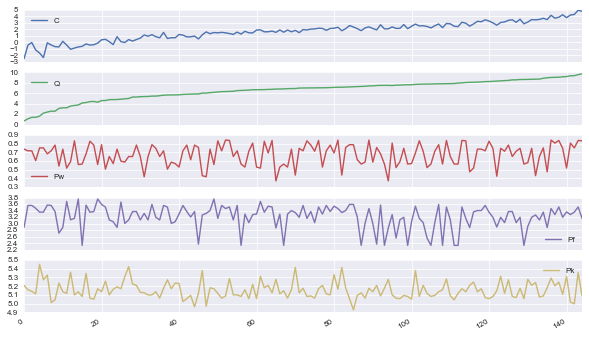

In [3]:
df.plot(subplots=True, figsize=(10, 6))
plt.show()

### OLS estimation

The model under consideration is
$$
\mathbb{E}\left[\log C\left|Q,P_{w},P_{f},P_{k}\right.\right]=\alpha_{1}+\alpha_{2}\log Q+\alpha_{3}\log P_{w}+\alpha_{4}\log P_{f}+\alpha_{5}\log P_{k}.
$$

In [4]:
Y = np.array(df['C'])
X = np.array(df[['Q', 'Pw', 'Pf', 'Pk']].T)
K, N = X.shape
res = ols(Y, X, 'White')
theta, se, V = res['beta'], res['s'], res['V']

## Confidence Intervals for individual parameters

### Asymptotic CI

In [5]:
%%time

CI_asy_hi = theta + norm.ppf(.975) * se
CI_asy_lo = theta - norm.ppf(.975) * se

print(theta)
print(CI_asy_hi)
print(CI_asy_lo)

[-3.527  0.72   0.436  0.427 -0.22 ]
[-0.217  0.783  0.909  0.572  0.404]
[-6.836  0.658 -0.037  0.281 -0.844]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.89 ms


### Bootstrap CI

In [6]:
def resample(Y, X):
    """Resample data randomly with replacement."""
    N = len(Y)
    ind = np.random.choice(N, size=N)
    return Y[ind], X[:, ind]

In [7]:
B = 100

# Initialize array for bootstrapped estimates and standard errors
theta_b = np.empty((B, K+1))
se_b = theta_b.copy()

for b in range(B):
    Yb, Xb = resample(Y, X)
    res = ols(Yb, Xb, 'White')
    theta_b[b], se_b[b], V_b = res['beta'], res['s'], res['V']

tstat_boot = np.abs(theta_b - theta) / se_b
q = np.percentile(tstat_boot, 95, axis=0)
CI_boo_hi = theta + q * se
CI_boo_lo = theta - q * se

print(theta)
print(CI_boo_hi)
print(CI_boo_lo)

[-3.527  0.72   0.436  0.427 -0.22 ]
[-0.247  0.799  0.87   0.565  0.355]
[-6.806  0.642  0.003  0.288 -0.795]


## Test for the linear combination of parameters

### Asymptotic

Test the hypothesis $H_{0}:\;\alpha_{3}+\alpha_{4}+\alpha_{5}=1$ against $H_{a}:\;\alpha_{3}+\alpha_{4}+\alpha_{5}<1$ at the 5% significance level.

In [8]:
# Parameter picker for testing linear restriction
r = np.array([0, 0, 1, 1, 1])

# T-statistics for the test
tstat = (theta[2:].sum() - 1) / (np.dot(r, V).dot(r))**.5
# Corresponding p-value
pval = norm.cdf(tstat)

print('T-statistics = %.4f' % tstat)
print('Asy. P-value = %.4f' % pval)

T-statistics = -0.8176
Asy. P-value = 0.2068


### Bootstrap

In [9]:
B = 100

# Initialize containers
theta_b = np.empty((B, K+1))
tstat_lin_b = np.empty(B)

for b in range(B):
    Yb, Xb = resample(Y, X)
    res = ols(Yb, Xb, 'White')
    theta_b, V_b = res['beta'], res['V']
    # Bootstrap t-statistic. Note recentering!
    tstat_lin_b[b] = (theta_b[2:].sum() - theta[2:].sum()) / (np.dot(r, V_b).dot(r))**.5

pval_b = np.sum(tstat_lin_b < tstat) / B
print('Boot. P-value = %.4f' % pval_b)

Boot. P-value = 0.1800


## Estimation under restriction

The restricted model is
$$
\mathbb{E}\left[\log C\left|Q,P_{w},P_{f},P_{k}\right.\right]=\alpha_{1}+\alpha_{2}\log Q+\alpha_{3}\left(\log P_{w}-\log P_{k}\right)+\alpha_{4}\left(\log P_{f}-\log P_{k}\right).
$$

In [10]:
Y = np.array(df['C'])
# Create new regressors
df['Pw-Pk'] = df['Pw'] - df['Pk']
df['Pf-Pk'] = df['Pf'] - df['Pk']
X = np.array(df[['Q', 'Pw-Pk', 'Pf-Pk']].T)

# Update the number of regressors
K, N = X.shape

def ols_restr(Y, X):
    # Estimate parameters via OLS
    res = ols(Y, X, 'White')
    theta_ols, V, se_ols = res['beta'], res['V'], res['s']
    # Append alpha_5  to the parameter vector
    theta_ols = np.append(theta_ols, 1 - theta_ols[2:].sum())
    # Parameter picker
    m = np.array([0, 0, -1, -1])
    # Append standard error of alpha_5
    se_ols = np.append(se_ols, (np.dot(m, V).dot(m))**.5)
    
    return theta_ols, se_ols

theta_ols, se_ols = ols_restr(Y, X)

print(theta_ols)
print(se_ols)

[-1.43   0.72   0.154  0.448  0.397]
[ 0.794  0.032  0.165  0.072  0.151]


### Asymptotic CI

In [11]:
%%time

CI_asy_hi = theta_ols + norm.ppf(.975) * se_ols
CI_asy_lo = theta_ols - norm.ppf(.975) * se_ols

print(theta_ols)
print(CI_asy_hi)
print(CI_asy_lo)

[-1.43   0.72   0.154  0.448  0.397]
[ 0.127  0.783  0.478  0.59   0.694]
[-2.986  0.657 -0.169  0.306  0.101]
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 4.92 ms


### Bootstrap CI

In [12]:
B = 100

theta_b = np.empty((B, K+2))
se_b = theta_b.copy()

for b in range(B):
    Yb, Xb = resample(Y, X)
    # Estimate restricted model using resampled data
    theta_b[b], se_b[b] = ols_restr(Yb, Xb)

# Bootstrapped t-statistics
tstat_boot = np.abs(theta_b - theta_ols) / se_b
# 95% Quantile
q = np.percentile(tstat_boot, 95, axis=0)

CI_boo_hi = theta_ols + q * se_ols
CI_boo_lo = theta_ols - q * se_ols

print(theta_ols)
print(CI_boo_hi)
print(CI_boo_lo)

[-1.43   0.72   0.154  0.448  0.397]
[-0.125  0.797  0.456  0.6    0.682]
[-2.734  0.642 -0.147  0.296  0.113]


## Non-linear least squares

Additional term in the regression is $\alpha_6Z$, where
$$
Z=\frac{\log Q}{1+\exp\left\{ \alpha_{7}-\log Q\right\} }.
$$

In [13]:
def nls_a7(df):
    """Estimation of non-linear model via concentration method.
    The function returns only the best alpha_7. Other parameters are computed conditional on that.
    """
    
    # Number of grid points
    steps = 10
    sum_e2 = []
    
    b7 = np.linspace(np.percentile(df['Q'], 10), np.percentile(df['Q'], 90), steps)
    theta_all, V_all = [], []

    Y = np.array(df['C'])
    df['Pw-Pk'] = df['Pw'] - df['Pk']
    df['Pf-Pk'] = df['Pf'] - df['Pk']

    for s in range(steps):
        df['Z'] = df['Q'] / (1 + np.exp(b7[s] - df['Q']))
        X = np.array(df[['Q', 'Pw-Pk', 'Pf-Pk', 'Z']].T)
        res = ols(Y, X, 'White')
        sum_e2.append(np.sum(res['e']**2))

    theta7 = b7[np.argmin(sum_e2)]
    
    return theta7, b7, sum_e2

### Use NLS to estimate parameters

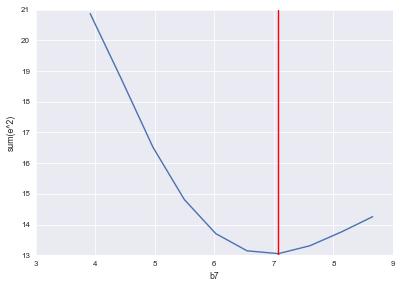

In [14]:
theta7, b7, sum_e2 = nls_a7(df)

plt.plot(b7, sum_e2)
plt.xlabel('b7')
plt.ylabel('sum(e^2)')
plt.axvline(b7[np.argmin(sum_e2)], color='red')
plt.show()

In [15]:
def nls(df, theta7):
    """Estimation of linear parameters given estimated non-linear parameter."""
    
    # Additional non-linear regressor given theta7
    df['Z'] = df['Q'] / (1 + np.exp(theta7 - df['Q']))
    # All regressors
    X = np.array(df[['Q', 'Pw-Pk', 'Pf-Pk', 'Z']].T)
    # OLS estimation
    res = ols(Y, X, 'White')
    
    # The derivative of non-linear regressor with parameter theta7
    df['Zprime'] = df['Z'] / (1 + np.exp(df['Q'] - theta7))
    # First-order approximation to non-linear regression
    M = np.array(df[['Q', 'Pw-Pk', 'Pf-Pk', 'Z', 'Zprime']].T)
    # Add constant
    M = np.concatenate((np.ones((1, N)), M), axis = 0)
    
    # Find standard errors corresponding to NLS estimates
    Qmm = np.dot(M, M.T)
    Me = M * res['e']
    Qmme = np.dot(Me, Me.T)
    V = np.dot(inv(Qmm), Qmme).dot(inv(Qmm))
    se = np.diag(V)**.5
    
    # Augment parameter vector with theta7
    theta = np.append(res['beta'], theta7)
    # Insert alpha_5
    theta = np.insert(theta, 4, 1 - theta[2:4].sum())

    # Parameter picker
    m = np.array([0, 0, -1, -1, 0, 0])
    # Insert standard error of alpha_5
    se = np.insert(se, 4, (np.dot(m, V).dot(m))**.5)
    
    return theta, se

### Asymptotic CI

In [16]:
theta, se = nls(df, theta7)

CI_asy_hi = theta + norm.ppf(.975) * se
CI_asy_lo = theta - norm.ppf(.975) * se

print(theta)
print(CI_asy_hi)
print(CI_asy_lo)

[-0.792  0.441  0.041  0.505  0.454  0.229  7.078]
[ 0.553  0.612  0.31   0.641  0.678  0.32   7.234]
[-2.136  0.27  -0.229  0.369  0.23   0.139  6.921]


### Bootstrap CI

In [17]:
def resample(df):
    """Resampling of the dataFrame."""
    N = Y.shape[0]
    ind = np.random.choice(N, size=N)
    return df.iloc[ind]

In [18]:
%%time

B = 100

theta_b = np.empty((B, K+4))
se_b = theta_b.copy()

for b in range(B):
    df_b = resample(df)
    theta7, b7, sum_e2 = nls_a7(df_b)
    theta_b[b], se_b[b] = nls(df_b, theta7)

tstat_boot = np.abs(theta_b - theta) / se_b
q = np.percentile(tstat_boot, 95, axis=0)

CI_boo_hi = theta + q * se
CI_boo_lo = theta - q * se

print(theta)
print(CI_boo_hi)
print(CI_boo_lo)

[-0.792  0.441  0.041  0.505  0.454  0.229  7.078]
[ 0.886  0.772  0.308  0.758  0.707  0.401  7.305]
[-2.469  0.111 -0.226  0.252  0.201  0.058  6.85 ]
CPU times: user 11.8 s, sys: 0 ns, total: 11.8 s
Wall time: 11.8 s
